ionize Tutorial
===============
**ionize** is a Python module for calculating the properties of ions and electrolyte solutions. 

In [1]:
# Setup
from __future__ import print_function, absolute_import, division
import ionize
import pprint

from matplotlib import pyplot as plot
%matplotlib inline

import numpy as np
np.set_printoptions(precision=3)

Ions
----
The basic building block that ionize is the a single ionic species. Small ions (as opposed to ion complexes or polyions) are represented by the **Ion** class. 

An Ion has the following properties that can be set on initialization. 

- name
- valence (as an interable of integers)
- reference_pKa (as an iterable of floats)
- reference_mobility (as an interable of floats, in m^2/V/s)
- reference_temperature, the temperature at which other parameters are measured, in degC (default = 25 degC)
- enthalpy, the change in enthalpy on ionization, as an interable, in J/mol/K
- heat_capacity, the change in heat_capacity on ionization, as an iterable, in J/mol/K^2
- molecular_weight, in Daltons
- alias, an iterable of alternate names
- nightingale_data, data fitting change in mobility with temperature

Only the name, valence, pKa, and mobility are required parameters. All other parameters are optional.

In [2]:
acid = ionize.Ion('myAcid', [-1], [5], [-25e-9])
base = ionize.Ion('myBase', [1], [8], [20e-9])
print(acid)        # The string includes only the class and name.
print(repr(base))  # The representation contains enough information to reconstruct the ion. 

Ion('myAcid')
Ion(valence=[1], heat_capacity=None, reference_temperature=25.0, name='myBase', molecular_weight=None, reference_pKa=[8.0], enthalpy=None, reference_mobility=[2e-08], nightingale_data=None, alias=None)


The guranteed interfaces of ion species are:
- charge(pH, ionic_strength, temperature)
    - Return the charge per ion at the specified condition
- mobility(pH, ionic_strength, temperature)
    - Return the effective mobility in m^2/V/s at the specified conditions
- diffusivity(pH, ionic_strength, temperature)
    - Return the diffusivity in m^2/s for the ion
- molar_conductivity(pH, ionic_strength, temperature)
    - Return the molar conductivity in S/M
- separability(other, pH, ionic_strength, temperature)
    - Return the separability between the ion and another ion at the specified condition.
- serialize(nested, compact)
    - Return a serialized JSON representation. 
- save(filename)
    - Save the ion to a file in JSON format.
    
In addition, BaseIon subclasses usually have some unique interfaced. 

myAcid Ka at (I=0 M) = [  1.001e-05]
myAcid Ka at (I=0.5 M) = [  1.781e-05]


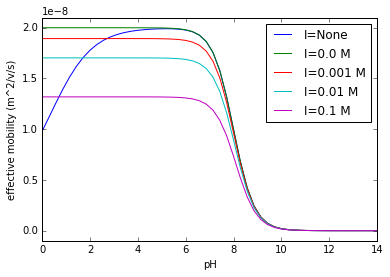

In [3]:
print('myAcid Ka at (I=0 M) =', acid.acidity())
print('myAcid Ka at (I=0.5 M) =', acid.acidity(ionic_strength=0.5))

pH = np.linspace(0,14)

for I in [None, 0., 0.001, 0.01, 0.1]:
    mu = [base.mobility(p, I) for p in pH]
    if I is not None:
        label = 'I={} M'.format(I)
    else:
        label = 'I=None'
    plot.plot(pH, mu, label=label)

plot.xlabel('pH'); plot.xlim(0, 14)
plot.ylabel('effective mobility (m^2/v/s)'); plot.ylim(-.1e-8, 2.1e-8)
plot.legend()
plot.show()

Note the difference between ionic_strength parameters here. If ionic_strength is 0, the numerical value of 0 is used in each calculation. However, it is impossible to have a solution of pH 0 with ionic_strength of 0. 

When the default value of None is used for ionic_strength, ionize uses the minimum ionic strength at the selected pH. 

**ionize** database
---------------------------

Individually initializing ions is error-prone and time-consuming. To simplify the process, load ions from 
the database by initializing the database, and accessing the database like a dictionary. 

Ion(valence=[-1, 1, 2], heat_capacity=[-233.0, 176.0, 0.0], reference_temperature=25.0, name='histidine', molecular_weight=155.15, reference_pKa=[9.33, 6.04, 2.0], enthalpy=[43800.0, 29500.0, 3600.0], reference_mobility=[-2.8300000000000002e-08, 2.8800000000000003e-08, 4.47e-08], nightingale_data=None, alias=None)


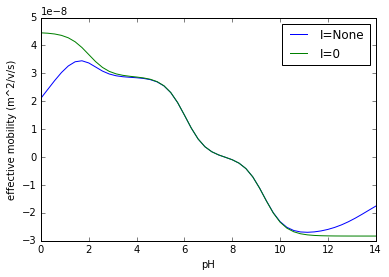

In [4]:
db = ionize.Database()
histidine = db['histidine']
print(repr(histidine))

for ionic_strength in (None, 0):
    mu_histidine = [histidine.mobility(p, ionic_strength=ionic_strength) for p in pH]
    plot.plot(pH, mu_histidine, label="I={}".format(ionic_strength))
    
plot.xlabel('pH'); plot.xlim([0, 14])
plot.ylabel('effective mobility (m^2/v/s)')
plot.legend()
plot.show()

### search()

You can also search for ions in the database by name using **search()** method of Database. search() will return a list of ion names, so load the ion when you find what you want. 

In [5]:
print("Search results for 'amino'\n--------------------------")
pprint.pprint(db.search('amino'))
print("\nSearch results for 'chloric'\n----------------------------")
pprint.pprint(db.search('chloric'))
print("\nSearch results for 'per'\n------------------------")
pprint.pprint(db.search('per'))
print('\nOh, copper is what I was looking for.')
print(db.load('copper'))

Search results for 'amino'
--------------------------
('2-amino-2-methyl-1-propanol',
 'e-aminocaproic acid',
 'gamma-aminobutyric acid',
 'o-aminobenzoic acid',
 'p-aminobenzoic acid')

Search results for 'chloric'
----------------------------
('chloric acid', 'hydrochloric acid', 'perchloric acid')

Search results for 'per'
------------------------
('copper',
 'diperodone',
 'perchloric acid',
 'periodic acid',
 'permanganic acid',
 'peroxysulfuric acid',
 'perrhenic acid',
 'piperidine')

Oh, copper is what I was looking for.
Ion('copper')


### Other db functions
You can get the database data as a dictionary using the data method.

In [6]:
print(len(db.data), 'ions in database.')

522 ions in database.


Solution
--------
Getting the properties of a single ionic species in solution is useful, but the real challenge of dealing with aqueous solutions of ions is finding properties based on the equilibrium state of multiple ionic species. **ionize** can perform those calculations using the **Solution** class. **Solution** objects are initialized using **ionize**.**Solution**(*ions*, *concentrations*), where ions is a list of **Ion** objects and concentration is a list concentrations of the ions, with concentrations in molar.

In [7]:
buffer=ionize.Solution([db['tris'], db['chloride']], [0.1, 0.085])

print('pH =', buffer.pH)
print('I =', buffer.ionic_strength, 'M')
print('conductivity =', buffer.conductivity(), 'S/m')
print('buffering capacity =', buffer.buffering_capacity(), 'M')
print('debye length =', buffer.debye(), 'm')

pH = 7.417824869226217
I = 0.08500041539867613 M
conductivity = 0.813690187538 S/m
buffering capacity = 0.029570419065 M
debye length = 1.4742500535996404e-09 m


/home/lewis/Documents/github/ionize/ionize/Ion/BaseIon.py:63: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  assert getattr(self, prop) == getattr(other, prop)


**Solutions** can be initialized with ion names instead of ion objects.

In [8]:
sol = ionize.Solution(['bis-tris', 'acetic acid'], [0.1, 0.03])
print([ion.name for ion in sol.ions])
print(sol.concentration('acetic acid'))

['bis-tris', 'acetic acid']
0.03


/home/lewis/Documents/github/ionize/ionize/Ion/BaseIon.py:63: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  assert getattr(self, prop) == getattr(other, prop)


We can iterate through solutions to calculate the pH of a titration between two ions.

In [9]:
c_tris = 0.1
c_hcl = np.linspace(0.0, 0.2, 50)
t_pH = [ionize.Solution(['tris', 'hydrochloric acid'], [c_tris, c_h]).pH for c_h in c_hcl]

plot.plot(c_hcl/c_tris, t_pH)
plot.xlabel('[HCl]/[Tris]')
plot.ylabel('pH')
plot.show()

/home/lewis/Documents/github/ionize/ionize/Ion/BaseIon.py:63: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  assert getattr(self, prop) == getattr(other, prop)


RuntimeError: Large ions may be contributing to charge, pH estimate is inaccurate.

A **Solution** can also be initialized without ions, e.g. as water. 

In [ ]:
water = ionize.Solution()
print('I =', water.ionic_strength, 'M')
print('pH =', water.pH)
print('conductivity =', water.conductivity(), 'S/m')

A Solution can also be added and multiplied. This can be useful when calculating the results of diltuions, as below.

In [ ]:
print('Stock:', buffer)
dilution = 0.5 * buffer + 0.5 * water
print('Dilution:', dilution)

**Solutions** can be titrated to a specified pH. To do so, make a solution, and then specify a titrant, a property, and a target.  

In [ ]:
buff = ionize.Solution(['tris'], 0.1)
print(buff.titrate('hydrochloric acid', 8.2))
print(buff.titrate('hydrochloric acid', 3))
print(buff.conductivity())
print(repr(buff.titrate('hydrochloric acid', 3, titration_property = 'conductivity')))
print(repr(buff.titrate('hydrochloric acid', 8)))